In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import time
import tqdm.notebook as tqdm

from pathlib import Path

%matplotlib inline


import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D, GlobalMaxPooling2D

In [2]:
DATA_DIR_PATH = "../data/bengali_AI_handwritten_grapheme_classification"

IMG_HEIGHT = 137
IMG_WIDTH = 236

COMBINED_LABEL_NUM = 1292
ROOT_CLASSES_NUM = 168
CONSONANT_CLASSES_NUM = 7
VOWEL_CLASSES_NUM = 11

In [3]:
original_train_df = pd.read_csv("{}/train.csv".format(DATA_DIR_PATH))
test_df = pd.read_csv("{}/test.csv".format(DATA_DIR_PATH))
class_map_df = pd.read_csv("{}/class_map.csv".format(DATA_DIR_PATH))
sample_submission_df = pd.read_csv("{}/sample_submission.csv".format(DATA_DIR_PATH))

In [4]:
def reshape_img(img_data):
    if isinstance(img_data, pd.Series):
        img_data = img_data.to_numpy()
    
    return img_data.reshape(IMG_HEIGHT, IMG_WIDTH)

In [5]:
def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.show()

In [6]:
CENTERED_IMAGE_PATH = "../data/bengali_centered"
PREPROCESSED_TRIAN_DATA_CSV_NAME = "new_train_data_with_new_label.csv"

In [7]:
def update_df_with_image_path(df: pd.DataFrame, dataset_name_list: list):
    image_path_list = list()

    for dataset_name in dataset_name_list:
        image_path_data_list = list()
        centered_image_dataset_path = os.path.join(CENTERED_IMAGE_PATH, dataset_name)

        for file in sorted(os.listdir(centered_image_dataset_path)):
            image_id, ext = os.path.splitext(file)

            if ext != ".jpg":
                continue

            idx = int(image_id.split("_")[-1])
            path_data = (idx, image_id, os.path.join(centered_image_dataset_path, file))

            image_path_data_list.append(path_data)

        image_path_data_list = sorted(image_path_data_list, key=lambda path_data: path_data[0])
        image_path_list_in_dataset = list(list(zip(*image_path_data_list))[2])
        image_path_list += image_path_list_in_dataset

    df['preprocessed_image_path'] = image_path_list

In [8]:
# update_df_with_image_path(df=original_train_df, dataset_name_list=["dataset_1", "dataset_2", "dataset_3", "dataset_4"])
# original_train_df.to_csv(os.path.join(CENTERED_IMAGE_PATH, PREPROCESSED_TRIAN_DATA_CSV_NAME), mode='w', index=False)

preprocessed_train_df = pd.read_csv(os.path.join(CENTERED_IMAGE_PATH, PREPROCESSED_TRIAN_DATA_CSV_NAME))

In [9]:
preprocessed_train_df.tail()

,Unnamed: 0,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,preprocessed_image_path,combined_word
200835,200835,Train_200835,22,7,2,র্খে,../data/bengali_centered/dataset_4/Train_20083...,22072
200836,200836,Train_200836,65,9,0,ত্তো,../data/bengali_centered/dataset_4/Train_20083...,65090
200837,200837,Train_200837,2,1,4,অ্যা,../data/bengali_centered/dataset_4/Train_20083...,2014
200838,200838,Train_200838,152,9,0,স্নো,../data/bengali_centered/dataset_4/Train_20083...,152090
200839,200839,Train_200839,127,2,0,ল্টি,../data/bengali_centered/dataset_4/Train_20083...,127020


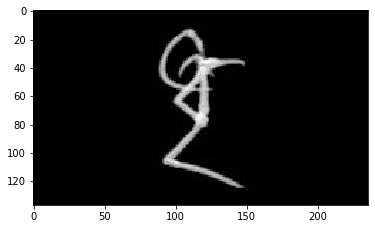

In [10]:
img = cv2.imread(preprocessed_train_df['preprocessed_image_path'][2700])
plt.imshow(img, cmap='gray')
plt.show()

In [11]:
preprocessed_train_df

,Unnamed: 0,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,preprocessed_image_path,combined_word
0,0,Train_0,15,9,5,ক্ট্রো,../data/bengali_centered/dataset_1/Train_0.jpg,15095
1,1,Train_1,159,0,0,হ,../data/bengali_centered/dataset_1/Train_1.jpg,159000
2,2,Train_2,22,3,5,খ্রী,../data/bengali_centered/dataset_1/Train_2.jpg,22035
3,3,Train_3,53,2,2,র্টি,../data/bengali_centered/dataset_1/Train_3.jpg,53022
4,4,Train_4,71,9,5,থ্রো,../data/bengali_centered/dataset_1/Train_4.jpg,71095
...,...,...,...,...,...,...,...,...
200835,200835,Train_200835,22,7,2,র্খে,../data/bengali_centered/dataset_4/Train_20083...,22072
200836,200836,Train_200836,65,9,0,ত্তো,../data/bengali_centered/dataset_4/Train_20083...,65090
200837,200837,Train_200837,2,1,4,অ্যা,../data/bengali_centered/dataset_4/Train_20083...,2014
200838,200838,Train_200838,152,9,0,স্নো,../data/bengali_centered/dataset_4/Train_20083...,152090


In [12]:
def get_len_train_test_split(full_len: int, test_ratio: float) -> tuple:
    test_len = int(full_len * test_ratio)
    train_len = full_len - test_len
    return train_len, test_len

In [13]:
def get_len_dataset(dataset) -> int:
    count = 0
    for data in dataset:
        count += 1
    
    return count

In [14]:
path_list = preprocessed_train_df['preprocessed_image_path']
label_list = preprocessed_train_df['combined_word']

batch_size = 256
epochs = 10

In [15]:
len_train, len_test_full = get_len_train_test_split(full_len=len(path_list), test_ratio=0.3)
len_val, len_test = get_len_train_test_split(full_len=len_test_full, test_ratio=0.7)

print(f"Train size : {len_train}, Val size : {len_val}, Test size : {len_test}")

Train size : 140588, Val size : 18076, Test size : 42176


In [16]:
print(type(path_list))
print(type(label_list))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [32]:
dataset = tf.data.Dataset.from_tensor_slices((path_list, label_list))

In [34]:
train_dataset = dataset.take(len_train)
test_dataset = dataset.skip(len_train)
val_dataset = test_dataset.take(len_val)
test_dataset = test_dataset.skip(len_val)

#print(f"Train size : {get_len_dataset(train_dataset)}, Val size : {get_len_dataset(val_dataset)}, Test size : {get_len_dataset(test_dataset)}")
# Train size : 140588, Val size : 18076, Test size : 42176

In [35]:
import efficientnet.tfkeras as efn

In [36]:
base_net = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [37]:
base_net.trainable = False

In [46]:
del model

In [47]:
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='img')

m = base_net(inputs)
m = GlobalMaxPooling2D()(m)


# m = Conv2D(32, 3, padding='same', activation='relu')(inputs)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Conv2D(64, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Conv2D(128, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Conv2D(256, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)


# m = Conv2D(512, 3, padding='same', activation='relu')(m)
# m = BatchNormalization(momentum=0.15)(m)
# m = MaxPool2D(pool_size=(2, 2))(m)
# m = Dropout(rate=0.3)(m)

# m = Flatten()(m)
# m = Dropout(rate=0.2)(m)

m = Dense(256, activation='relu')(m)
m = Dropout(rate=0.3)(m)
m = Dense(128, activation='relu')(m)
m = Dropout(rate=0.2)(m)

output = Dense(COMBINED_LABEL_NUM, activation='softmax', name='output')(m)

In [48]:
model = tf.keras.Model(inputs=inputs, outputs=output)

In [49]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 137, 236, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Model)      (None, 5, 8, 1280)        4049564   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0   

In [50]:
from tensorflow.keras.utils import plot_model

In [51]:
plot_model(base_net)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [52]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
def read_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img

def load_img(path_list):
    return tf.map_fn(read_img, path_list, dtype=tf.float32)

In [54]:
history_list = list()

for epoch in range(50):
    
    print("== Epoch : {} ==\n".format(epoch))
    dataset = dataset.shuffle(len(path_list))
    
    for path_batch, label_batch in train_dataset.batch(1280):
#     for path_batch, root_batch, consonant_batch, vowel_batch in train_dataset.batch(1024).take(2):
        time_st = time.time()
        img_batch = tf.map_fn(read_img, path_batch, dtype=tf.float32)
        time_ed = time.time()
        print("Elapsed time for loading image data : {}".format(time_ed - time_st))
        
        history = model.fit(
            generator
            x={'img': img_batch},
            y={'output': label_batch},
            batch_size=32  # 64, 128, 256 은 GPU 메모리 부족
        )
        
        # Appending history
        history_list.append((epoch, history))
    
    print(f"Epoch {epoch} - ")

== Epoch : 0 ==

Elapsed time for loading image data : 0.9926254749298096
Train on 1280 samples
1280/1280 [==============================] - 4s 3ms/sample - loss: 21755899688.0000 - accuracy: 0.0000e+00
Elapsed time for loading image data : 0.9443461894989014
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 245811088179.2000 - accuracy: 0.0000e+00
Elapsed time for loading image data : 0.970935583114624
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 940575725158.3999 - accuracy: 0.0000e+00
Elapsed time for loading image data : 1.0294115543365479
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 2145295666380.7998 - accuracy: 0.0000e+00
Elapsed time for loading image data : 1.0240938663482666
Train on 1280 samples
1280/1280 [==============================] - 2s 1ms/sample - loss: 3857806675148.8003 - accuracy: 0.0000e+00
Elapsed time for loading image data : 1.01889538

KeyboardInterrupt: 